In [1]:
import jax 
from jax import config
config.update("jax_enable_x64", True)

import jax.numpy as jnp
from jax import grad, jit, vmap
import jax.scipy as jsp 

import drpangloss
# from drpangloss.oifits_implaneia import load_oifits, cp_indices
from drpangloss.models import BinaryModelAngular, BinaryModelCartesian, OIData

import zodiax as zx
import equinox as eqx

import pyoifits as oifits

from functools import partial
import matplotlib.pyplot as plt

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
fname = "alfPic_PIONIER.fits"
ddir = "../data/"

data = oifits.open(ddir+fname)
oidata = OIData(data)

In [48]:
init_values = [-76.0532, -26.3609, 0.03]
params = ["dra", "ddec", "flux"]
param_dict = dict(zip(params, init_values))
model_data = oidata.model(BinaryModelCartesian(**param_dict))

In [53]:
def loglike(data_obj, model_class, params, values):
    param_dict = dict(zip(params, values))
    
    model_data = data_obj.model(model_class(**param_dict))
    data, errors = data_obj.flatten_data()
    return -0.5*jnp.sum((data - model_data)**2/errors**2)

@partial(jit, static_argnames=("model_class"))
def likelihood_grid(data_obj, model_class, samples_dict):
    # Louis suggested syntax for nice vmap over grids 
    
    params = list(samples_dict.keys())
    samples = samples_dict.values()
    vals = jnp.array(jnp.meshgrid(*samples))
    vals_vec = vals.reshape((len(vals), -1)).T
    
    fn = vmap(lambda values: loglike(data_obj,model_class,params,values))

    return fn(vals_vec).reshape(vals.shape[1:]) # check the shapes output here

In [54]:
loglike(oidata,BinaryModelCartesian,params,init_values) # once to jit

Array(-83.32596185, dtype=float64)

In [74]:
samples_dict = {
    "dra":  jnp.linspace(300., -300., 100), # left is more RA 
    "ddec": jnp.linspace(-300., 300., 100), # up is more dec
    "flux": 10.**jnp.linspace(-4, 0, 100)}

loglike_im = likelihood_grid(oidata, BinaryModelCartesian, samples_dict) # calculate once to jit

In [75]:
%%time
loglike_im = likelihood_grid(oidata, BinaryModelCartesian, samples_dict)

CPU times: user 3.98 s, sys: 15.5 ms, total: 3.99 s
Wall time: 634 ms


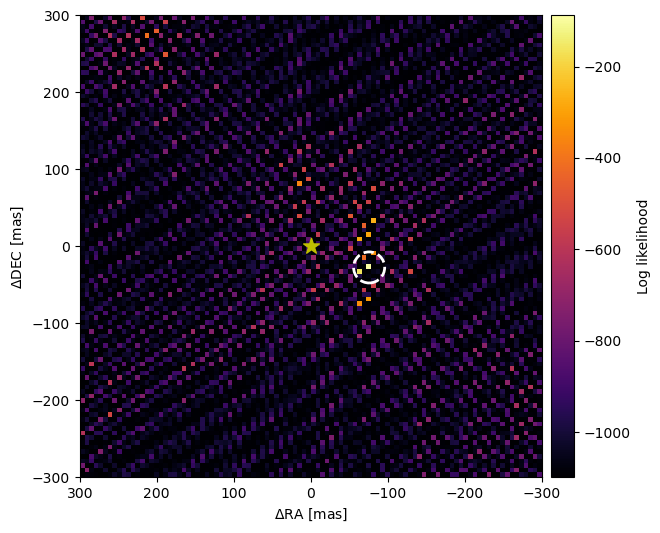

In [92]:
plt.figure(figsize=(12,6))

plt.imshow(loglike_im.max(axis=2).T, cmap="inferno",aspect="equal",
           extent = [samples_dict["dra"].max(), samples_dict["dra"].min(), # this may seem weird, but left is more RA and up is more Dec
                        samples_dict["ddec"].max(), samples_dict["ddec"].min()]) # this took me far too long to get the sign right for
plt.colorbar(shrink=1,label='Log likelihood', pad=0.01)
plt.scatter(0,0,s=140,c='y',marker='*')

plt.xlabel('$\\Delta$RA [mas]')
plt.ylabel('$\\Delta$DEC [mas]')

dra_inp, ddec_inp = init_values[0], init_values[1]
plt.scatter(dra_inp,ddec_inp, 
           s=500,linestyle='--', facecolors='none', edgecolors='white',linewidths=2,alpha=1)
plt.gca().invert_yaxis() # up is more Dec


In [80]:
i, j, k = jnp.unravel_index(jnp.argmax(loglike_im, axis=None), loglike_im.shape)
best_ra, best_dec, best_flux = samples_dict["dra"][i], samples_dict["ddec"][j], samples_dict["flux"][k]

In [84]:
print(best_ra, best_dec, best_flux)

-75.7575757575758 -27.272727272727252 0.04229242874389501


(0.0, 1.1)

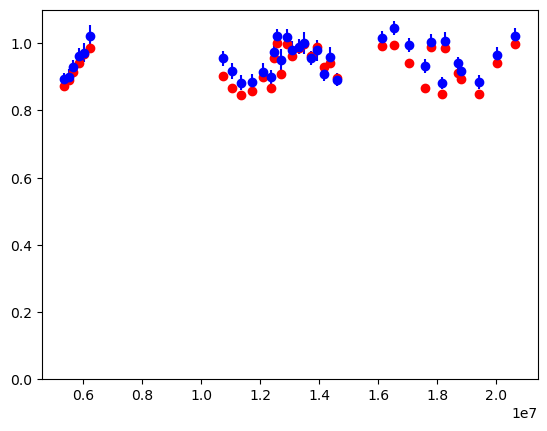

In [90]:
init_values = [best_ra, best_dec, best_flux]
params = ["dra", "ddec", "flux"]
param_dict = dict(zip(params, init_values))
model_data = oidata.model(BinaryModelCartesian(**param_dict))
data, errors = oidata.flatten_data()
x = jnp.concatenate(jnp.sqrt(oidata.u**2+oidata.v**2)[:,jnp.newaxis]/oidata.wavel, axis=0)
plt.errorbar(x, jnp.concatenate(data[0:6,:], axis=0), yerr=jnp.concatenate(errors[0:6,:], axis=0), fmt='bo', label="Data")
plt.plot(x, jnp.concatenate(model_data[0:6,], axis=0), 'ro', label="Model")
plt.ylim(0,1.1)